In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime

In [2]:
%run -i "D:/crs/src/NOPP_Utilities/storm_coords.py"
%run -i "D:/crs/src/NOPP_Utilities/scat_stats.py"

In [3]:
# Pamlico Sound model results
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/dorian_coupled11/PAM/dorian_his.ncml'
dsm = xr.open_dataset(url)
latm = dsm.lat_rho.values
lonm = dsm.lon_rho.values
timem = dsm.ocean_time.values

In [4]:
# Target date
start_date = np.datetime64('2019-09-03 00:00:00')
end_date = np.datetime64('2019-09-07 00:00:00')
tol = np.timedelta64(14, 'm') # not used

In [5]:
# Data directory for observations downloaded using the Flood Event Viewer https://stn.wim.usgs.gov/fev/#2019Dorian
data_dir = 'D:/crs/docs/papers/2023_Warner_Dorian_paper/WL_Waves_data/'
# List of stations

sta_list = ['NCBEA11728',
            'NCCAR12328',
            'NCCRV00003',
            'NCHYD00001',
            'NCPAM13231']
url_list = ['NCBEA11728_stormtide_unfiltered.nc',
            'NCCAR12328_stormtide_unfiltered.nc',     
            'NCCRV00003_stormtide_unfiltered.nc',  
            'NCHYD00001_stormtide_unfiltered.nc',
            'NCPAM13231_stormtide_unfiltered.nc']

print(sta_list)
print(url_list)

['NCBEA11728', 'NCCAR12328', 'NCCRV00003', 'NCHYD00001', 'NCPAM13231']
['NCBEA11728_stormtide_unfiltered.nc', 'NCCAR12328_stormtide_unfiltered.nc', 'NCCRV00003_stormtide_unfiltered.nc', 'NCHYD00001_stormtide_unfiltered.nc', 'NCPAM13231_stormtide_unfiltered.nc']


In [6]:
# Correction from model datum (MSL = 0.32) to WL datum (NAVD88 = 0.39) at Hattaras
# NAVD88 = MSL + zcorr (m)
zcorr = -0.07 

In [7]:
for i, url in enumerate( url_list ):

    # Get buoy information
    ds = xr.open_dataset( data_dir + url )
    lato = ds['latitude'].values
    lono = ds['longitude'].values
    sensor_elev = ds.attrs['sensor_orifice_elevation_at_deployment_time']
    print('\n',sta_list[i], 'sensor_elev:', sensor_elev)
    print('{:.3f}, {:.3f}'.format(lato, lono))
    time_all = ds['time'].values
    time_diffs = ds['time'].diff(dim='time')
    time_diffs_seconds = time_diffs.dt.total_seconds()
    # Print the first five elements as float values
    # print('Time differences in seconds:', time_diffs_seconds[:5].values)
    sample_interval = np.round( np.median( time_diffs_seconds ), 3 )
    
    # Get indices for start/end times
    idxws = int( np.where(time_all >= start_date)[0][0] )
    idxwe = int( np.where(time_all <= end_date)[0][-1] )
    timeo = time_all[idxws:idxwe]
    # timeo = ds['time'][idxws:idxwe].values
    
    # Get WL time series
    wlufo = np.squeeze( ds.unfiltered_water_surface_height_above_reference_datum[idxws:idxwe].values )
    wlo = np.squeeze( ds.water_surface_height_above_reference_datum[idxws:idxwe].values )
    
    # Smooth unfiltered observations over 10 minutes
    # TODO - How best to filter? Esp. for ts with missing values or that go dry
    # How many points?
    npts = 1.+600./sample_interval
    print('sample_interval: ', sample_interval, 'smoothing over: ',npts)
    wghts = np.ones(int(npts)) / npts  # Equal weights for averaging
    # Apply the running average
    wlufos = np.convolve(wlufo, wghts, mode='same')
    # Remove points below the sensor elevation plus some arbitrary fudge factor
    sla = sensor_elev+0.05
    wlufo[wlufo<=sla]=sla
    wlufos[wlufos<=sla]=np.nan

    # Find closest model grid point
    # Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
    model_shape = np.shape( lonm )
    print('model shape: ',model_shape)
    mask_rho = dsm.mask_rho.values
    print('nlat, nlon: ',np.shape(mask_rho))
    
    # Find the indices of the nearest lat/lon
    dist = haversine( (lonm*mask_rho), (latm*mask_rho) , lono, lato )
    ilatm, ilonm = np.argwhere( dist == np.min(dist) ).squeeze()  
    print('ilatm, ilonm:', ilatm, ilonm )
    # Get the water depth
    hm  = dsm.h[ilatm, ilonm].values
    print('elev',sensor_elev,', model depth: ',hm,' distance apart:',dist[ilatm,ilonm])

    # # Plot the grids, buoy locations, and corresponding grid point
    # if i==0:
    #     _ = plt.plot((lonm*mask_rho).flatten(), (latm*mask_rho).flatten(), '.')
    #     plt.xlim(-77.5, -75)
    #     plt.ylim(34, 37)
    # plt.plot(lonm[ilatm, ilonm], latm[ilatm, ilonm], 'oy', ms = 8 )
    # plt.plot(lono, lato, '.r', ms=6 )

    # Find the observation times that correspond with model time
    time_threshold = (.9*sample_interval)
    # Empty arrays to hold indices into each time series
    oindex_list = []
    mindex_list = []
    
    # Loop through each time in dataset_time1
    for i, mt in enumerate(timem):
        # Calculate absolute time differences between the current model time and all times in obs. time
        time_diffs = np.abs(timeo - mt)
        
        # Find the nearest index within the threshold
        idx = np.argmin(time_diffs)
        
        # Check if the nearest time difference is within the threshold
        if time_diffs[idx].astype(float) <= time_threshold.astype(float):
            # Append to the index lists
            oindex_list.append(idx)
            mindex_list.append(i)
    
    # Observation times are a subset (i indicates interpolated times)
    timeoi = timeo[oindex_list]
    wlufosi = wlufos[oindex_list]
    # Model times usually include all hourly times
    timemi = timem[mindex_list]
    # Get model data for specified times, lat, and lons
    wlm = dsm.zeta.values[mindex_list, ilatm, ilonm]
    # Adjust model data accoriding to datums, assuming model is MSL and obs. are NAVD88.
    # zcorr = MSL - NAVD88 = 0.32 - 0.39 = -0.07
    print('adding ',zcorr,' to model output')
    wlm = wlm + zcorr
    print(np.shape(wlm), np.shape(wlufosi))

    # Calclulate scatter stats
    a, s = scat_stats_string( wlm, wlufosi, sep_lines=True )
    txt = 'Bias: {0:.3f}\nRMSE: {1:.3f}\nNRMSE: {2:.3f}\nrho : {3:.3f}' \
        .format( a[4],a[2],a[5],a[3])
    print(s)
    print(txt)




 NCBEA11728 sensor_elev: 0.2896
35.377, -76.748
sample_interval:  30.0 smoothing over:  21.0
model shape:  (857, 1067)
nlat, nlon:  (857, 1067)
ilatm, ilonm: 416 300
elev 0.2896 , model depth:  -0.4958528001142083  distance apart: 0.10248957656578518
adding  -0.07  to model output
(80,) (80,)
N: 80
Nnan: 40
RMSE: 0.213
rho: 1.000
Bias: 0.135
NRMSE: 0.348
HH: 0.313
Bias: 0.135
RMSE: 0.213
NRMSE: 0.348
rho : 1.000

 NCCAR12328 sensor_elev: 0.7376
34.697, -76.727
sample_interval:  0.25 smoothing over:  2401.0
model shape:  (857, 1067)
nlat, nlon:  (857, 1067)
ilatm, ilonm: 131 164
elev 0.7376 , model depth:  1.033112307608253  distance apart: 0.1076233670921807
adding  -0.07  to model output
(85,) (85,)
N: 85
Nnan: 33
RMSE: 0.601
rho: 1.000
Bias: -0.548
NRMSE: 0.659
HH: 1.017
Bias: -0.548
RMSE: 0.601
NRMSE: 0.659
rho : 1.000

 NCCRV00003 sensor_elev: 0.0762
34.936, -76.811
sample_interval:  30.0 smoothing over:  21.0
model shape:  (857, 1067)
nlat, nlon:  (857, 1067)
ilatm, ilonm: 245 17

NameError: name 'wtime1' is not defined

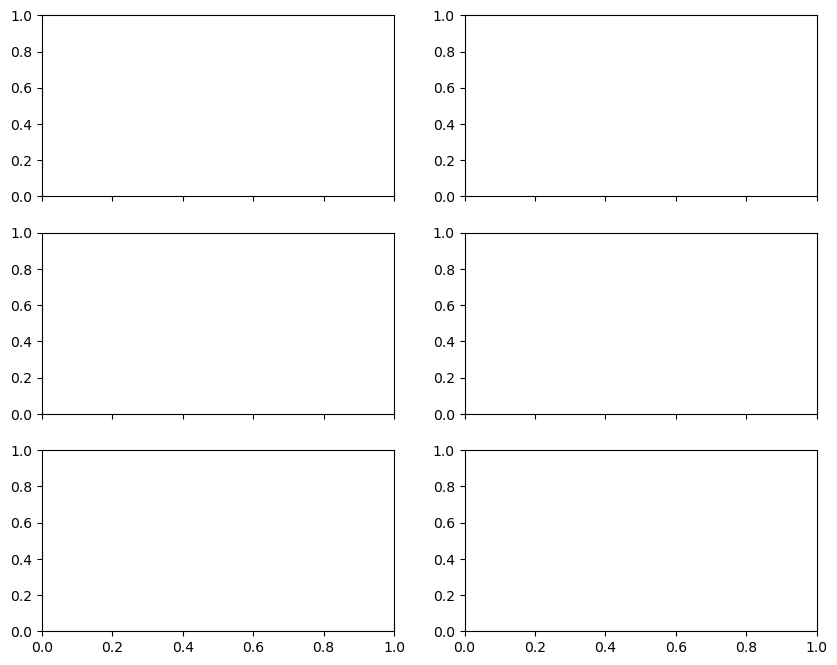

In [8]:
# Create an array with 12-hour increments
x_ticks = np.arange(start_date, end_date+np.timedelta64(12, 'h'), np.timedelta64(12, 'h'))

# Format the tick labels (e.g., 'MM-DD HH:MM' format)
x_labels = [pd.Timestamp(x).strftime('%m-%d %H') for x in x_ticks]

fig, axs = plt.subplots( 3, 2, sharex=True, sharey=False, figsize=( 10, 8 ) )

axs[0,0].plot(wtime1, Hso1, '-k', label='Observations')
axs[0,0].plot(mtimei1, Hsm1, '-', c='tab:red', label='Model')
a, s = scat_stats_string( Hsm1, Hso1i, sep_lines=True )
txt = 'Bias: {0:.2f}\nRMSE: {1:.2f}\nNRMSE: {2:.2f}' \
    .format( a[4],a[2],a[5])
axs[0,0].text(.05, .6, txt, fontsize=10, transform=axs[0,0].transAxes )
axs[0,0].text(.03, .9, 'A', fontsize=12, transform=axs[0,0].transAxes )
axs[0,0].text(.97, .9, 'Buoy 41159', fontsize=12, ha='right', transform=axs[0,0].transAxes )

axs[0,0].set_ylim((0,10))
axs[0,0].set_ylabel('Wave Height $H_s$ (m)')
axs[0,0].legend(loc='upper center')

axs[0,1].plot(wtime2, Hso2, '-k')
axs[0,1].plot(mtimei2, Hsm2, '-', c='tab:red' )
a, s = scat_stats_string( Hsm2, Hso2i, sep_lines=True )
txt = 'Bias: {0:.2f}\nRMSE: {1:.2f}\nNRMSE: {2:.2f}' \
    .format( a[4],a[2],a[5])
axs[0,1].text(.05, .6, txt, fontsize=10, transform=axs[0,1].transAxes )
axs[0,1].text(.03, .9, 'D', fontsize=12, transform=axs[0,1].transAxes )
axs[0,1].set_ylim((0,10))
axs[0,1].set_yticklabels([])
axs[0,1].text(.97, .9, 'Buoy 41025', fontsize=12, ha='right', transform=axs[0,1].transAxes )


axs[1,0].plot(wtime1, Dmo1, '+k')
axs[1,0].plot(mtimei1, Dmm1, '-', c='tab:red')
a, s = scat_stats_string( Dmm1, Dmo1i, sep_lines=True )
txt = 'Bias: {0:.2f}\nRMSE: {1:.2f}\nNRMSE: {2:.2f}' \
    .format( a[4],a[2],a[5])
axs[1,0].text(.05, .65, txt, fontsize=10, transform=axs[1,0].transAxes )
axs[1,0].text(.03, .9, 'B', fontsize=12, transform=axs[1,0].transAxes )

axs[1,0].set_ylim((0,360))
axs[1,0].set_yticks([0, 90, 180, 270, 360])
axs[1,0].set_ylabel('Direction ($\circ$T)')

axs[1,1].plot(wtime2, Dmo2, '+k')
axs[1,1].plot(mtimei2, Dmm2, '-', c='tab:red')
a, s = scat_stats_string( Dmm2, Dmo2i, sep_lines=True )
txt = 'Bias: {0:.2f}\nRMSE: {1:.2f}\nNRMSE: {2:.2f}' \
    .format( a[4],a[2],a[5])
axs[1,1].text(.05, .65, txt, fontsize=10, transform=axs[1,1].transAxes )
axs[1,1].text(.03, .9, 'E', fontsize=12, transform=axs[1,1].transAxes )
axs[1,1].set_ylim((0,360))
axs[1,1].set_yticks([0, 90, 180, 270, 360])
axs[1,1].set_yticklabels([])

axs[2,0].plot(wtime1, Tpo1, '+k')
axs[2,0].plot(mtimei1, Tpm1, '-', c='tab:red')
a, s = scat_stats_string( Tpm1, Tpo1i, sep_lines=True )
txt = 'Bias: {0:.2f}\nRMSE: {1:.2f}\nNRMSE: {2:.2f}' \
    .format( a[4],a[2],a[5])
axs[2,0].text(.05, .65, txt, fontsize=10, transform=axs[2,0].transAxes )
axs[2,0].text(.03, .9, 'C', fontsize=12, transform=axs[2,0].transAxes )

axs[2,0].set_ylim((4,16))
axs[2,0].set_xticks( x_ticks )
axs[2,0].set_xticklabels(x_labels, rotation=45, ha="right")
axs[2,0].set_ylabel('Peak Period $T_p$ (s)')

axs[2,1].plot(wtime2, Tpo2, '+k')
axs[2,1].plot(mtimei2, Tpm2, '-', c='tab:red')
a, s = scat_stats_string( Tpm2, Tpo2i, sep_lines=True )
txt = 'Bias: {0:.2f}\nRMSE: {1:.2f}\nNRMSE: {2:.2f}' \
    .format( a[4],a[2],a[5])
axs[2,1].text(.05, .65, txt, fontsize=10, transform=axs[2,1].transAxes )
axs[2,1].text(.03, .9, 'F', fontsize=12, transform=axs[2,1].transAxes )
axs[2,1].set_ylim((4,16))
axs[2,1].set_yticklabels([])
axs[2,1].set_xticks( x_ticks )
axs[2,1].set_xticklabels(x_labels, rotation=45, ha="right")
plt.tight_layout()
plt.savefig('dorian_wave_stats_comparison.png', bbox_inches='tight', dpi=200)